# Infidelity optimization on the quench dynamics of the Transverse Field Ising Model
we present the state optimization for the update at time $Jt = 1.25 \rightarrow 1.30$ when performing a full-basis simulation of the quench dynamics of the 2D transverse field Ising Model
$$
    H = -4J\sum_{\langle i,j\rangle } S^z_iS^z_j - 2h\sum_iS^x_i
$$
from $h = \infty$ to $h = h_c/10$, on a $4\times 4$

This notebook takes about 15 minutes to run on a modern GPU.

In [16]:
import netket as nk 
import matplotlib.pyplot as plt 
import optax
import jax.numpy as jnp
from netket.callbacks import InvalidLossStopping
from copy import copy, deepcopy

import advanced_drivers as advd
from  grad_sample.ansatz import CNN
from grad_sample.models import TFI
from ptvmc.nn import DiagonalWrapper
from grad_sample.utils import e_diag, save_exact_infidelity

In [17]:
# Define VMC hparams
Ns = 2**13
n_iter = 500
lr= 5e-2
diag_shift= 1e-7
opt = optax.inject_hyperparams(optax.sgd)(learning_rate=lr)
solver_fn = nk.optimizer.solver.cholesky()

### Variational State creation
- Instead of the usual Metropolis sampler, we will resort to an exact sampler due to the small system size. This will speed up the optimization.
- As an ansatz, we employ the Neural Network backflow which takes the following form:
$$ $$

In [18]:
model = TFI(L = 4, h = 0.3044, J = -1.0)

def create_vstate():
    net = CNN( 
                lattice=model.graph,
                kernel_size=[3,3],
                channels=[10,10,10,10]
                )
    
    ansatz = DiagonalWrapper(network=net,
                             param_dtype= complex)
    sampler = nk.sampler.ExactSampler(hilbert = model.hilbert_space)

    # load init state
    vs_fs = nk.vqs.FullSumState.load('importance_sampling_nqs/data/infidelity_states/state_1.25000.nk')

    vstate = nk.vqs.MCState(sampler= sampler, 
                            model=ansatz, 
                            n_samples= Ns,
                            seed=0,
                            variables = vs_fs.variables
                            )
    
    # load target state
    ts_fs = nk.vqs.FullSumState.load('importance_sampling_nqs/data/infidelity_states/state_1.30000.nk')
    ts = copy(vstate)
    ts.variables = deepcopy(ts_fs.variables)

    return vstate, ts

In [19]:
pi_cb = advd._src.callbacks.autodiagshift.PI_controller_diagshift(
    target= 0.9,
    safety_fac=1.,
    clip_min= 0.5,
    clip_max= 2,
    diag_shift_min=1e-9,
    diag_shift_max= 1e-1,
    order= 1,
    beta_1=0.9,
    beta_2=0.1,
    max_step_attempts= 5)

### Sampling from $|\psi|^2$
Let's start by the usual case where we sample from the Born amplitude

In [20]:
vstate, ts = create_vstate()
sampling_state_distribution = advd.driver.overdispersed_distribution(alpha=2.0)
sampling_target_distribution = advd.driver.overdispersed_distribution(alpha=2.0)
driver = advd.driver.InfidelityOptimizerNG(
            target_state=ts,
            optimizer=opt,
            diag_shift=diag_shift,
            linear_solver_fn=solver_fn,
            variational_state=vstate,
            use_ntk=False,
            chunk_size_bwd=1024,
            sampling_state_distribution=sampling_state_distribution,
            sampling_target_distribution=sampling_target_distribution,
            U=None,
            V=None,
        )
out_psi_sq = nk.logging.RuntimeLog()
driver.run(n_iter = n_iter, out = out_psi_sq, callback = (InvalidLossStopping(), pi_cb, save_exact_infidelity()))

 66%|▋| 330/500 [05:42<02:55,  1.03s/it, Infidelity=5.17

ρ is out of bounds. The current value is (-0.04641591983234503-0j). The bounds are [0.1,3]. 



100%|█| 500/500 [08:25<00:00,  1.01s/it, Infidelity=1.30


(RuntimeLog():
  keys = ['adaptive_diagshift', 'Infidelity', 'info', 'inf_fs', 'constrained_norm', 'rejected_steps'],)

### Sampling from $|\psi|^{\frac12}$

In [21]:
vstate, ts = create_vstate()
sampling_state_distribution = advd.driver.overdispersed_distribution(alpha=0.5)
sampling_target_distribution = advd.driver.overdispersed_distribution(alpha=0.5)
driver = advd.driver.InfidelityOptimizerNG(
            target_state=ts,
            optimizer=opt,
            diag_shift=diag_shift,
            linear_solver_fn=solver_fn,
            variational_state=vstate,
            use_ntk=False,
            chunk_size_bwd=1024,
            sampling_state_distribution=sampling_state_distribution,
            sampling_target_distribution=sampling_target_distribution,
            U=None,
            V=None,
        )
out_psi_sqrt = nk.logging.RuntimeLog()
driver.run(n_iter = n_iter, out = out_psi_sqrt, callback = (InvalidLossStopping(), pi_cb, save_exact_infidelity()))

 12%| | 60/500 [00:57<07:41,  1.05s/it, Infidelity=8.239

100%|█| 500/500 [07:47<00:00,  1.07it/s, Infidelity=5.40


(RuntimeLog():
  keys = ['adaptive_diagshift', 'Infidelity', 'info', 'inf_fs', 'constrained_norm', 'rejected_steps'],)

### Let's compare !

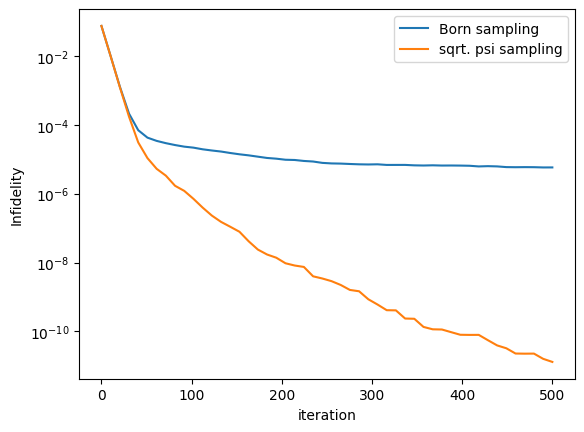

In [22]:
plt.plot(jnp.linspace(0,n_iter,n_iter//10), out_psi_sq['inf_fs'], label = 'Born sampling')
plt.plot(jnp.linspace(0,n_iter,n_iter//10), out_psi_sqrt['inf_fs'], label = 'sqrt. psi sampling')
# plt.plot(jnp.linspace(0,n_iter,n_iter//10), out_psi_auto['rel_err'], label = 'adaptive tuning')

plt.ylabel('Infidelity')
plt.xlabel('iteration')

plt.yscale('log')

plt.legend()
plt.show()